In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi
!nvidia-smi

Tue Dec 12 14:16:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
_exp_name =  "all_data"

### import packages

In [ ]:
import numpy as np
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image

# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import DataLoader, Dataset

# This is for the progress bar.
from tqdm.auto import tqdm
import random

# ploting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# models
import torchvision.models as models

### Set Random seed

In [ ]:
myseed = 66666
random.seed(myseed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

### Hyper-parameters

In [ ]:
batch_size = 64

_dataset_dir = "/content/drive/MyDrive/" # directory to get the data

# Training set dir -> _dataset_dir + "/train"
# Validation set dir -> _dataset_dir + "/valid"
# Testing set dir -> _dataset_dir + "/test"

# training loop
early_stop_steps = 5
num_epochs = 30

# optimizer
learning_rate = 1e-4
weigth_decay = 1e-6

# transforms for data augmentation
image_size = 192

# transform for testing set
test_tfm = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# transform for training set
# more trasforms: https://pytorch.org/vision/stable/transforms.html

train_tfm = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomApply([
        transforms.RandomApply([transforms.CenterCrop((160,160))], p=0.4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([transforms.RandomRotation(10, expand=False, center=None, fill=256)], p=0.35),
        transforms.RandomApply([transforms.Pad(10, fill=256, padding_mode='constant')], p=0.3),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0, saturation=0, hue=0)], p=1),
        transforms.RandomApply([transforms.ColorJitter(brightness=0, contrast=0.4, saturation=0, hue=0)], p=0.3),
        transforms.RandomApply([transforms.ColorJitter(brightness=0, contrast=0, saturation=0.4, hue=0)], p=0.3),
        ],
    p=0.98),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

### Dataset
class for data loader in pytorch

intit-> load the datas to a list

getitem-> return an image and its label every time its called

In [ ]:
class FaceDataset(Dataset):

    def __init__(self,path,set,tfm=test_tfm,files = None):
        super(FaceDataset).__init__()
        self.path = path
        self.files = []
        ### ===== get the files ==== ###
        # self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])


        # manipulated videos
        for i in tqdm(range(0, 12)):
            curr_path = os.path.join(path, f"manipulated_faces_{i}/{set}")
            self.files.extend(sorted([os.path.join(curr_path,x) for x in os.listdir(curr_path) if x.endswith(".jpg")]))

        manipulated_size = len(self.files)

        curr_path = os.path.join(path, f"source_faces/{set}")
        self.files.extend(sorted([os.path.join(curr_path,x) for x in os.listdir(curr_path) if x.endswith(".jpg")]))

        curr_path = os.path.join(path, f"source_faces_2/{set}")
        self.files.extend(sorted([os.path.join(curr_path,x) for x in os.listdir(curr_path) if x.endswith(".jpg")]))

        source_size = len(self.files) - manipulated_size

        print(f"[ DATA DISTRIBUTION ] | [ FAKE ] : {manipulated_size} | [ REAL ] : {source_size}")

        random.shuffle(self.files)
        print(f"One {path} sample",self.files[0])

        if files != None:
            self.files = files

        ### ==== ====###

        self.transform = tfm

    def __len__(self):
        return len(self.files)

    def __getitem__(self,idx):
        ### ==== return an image and its label ==== #
        fname = self.files[idx]
        im = Image.open(fname)

        # data augmentation
        im = self.transform(im)

        # get the label for training
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
        #print(fname)
        #print(fname.split("\\")[-1].split("_")[0])
        return im,label

### CNN Model

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input dimention [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 192, 192]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 96, 96]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 96, 96]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 48, 48]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 48, 48]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 24, 24]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 24, 24]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 12, 12]

            nn.Conv2d(512, 512, 3, 1, 1), # [512, 12, 12]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 6, 6]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*6*6, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

### Get device

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"using {device}")

using cuda:0


### Load Data

In [ ]:
# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = FaceDataset(_dataset_dir, "train", tfm=train_tfm)
valid_set = FaceDataset(_dataset_dir, "valid", tfm=test_tfm)

random.shuffle(valid_set.files)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

  0%|          | 0/12 [00:00<?, ?it/s]

[ DATA DISTRIBUTION ] | [ FAKE ] : 21664 | [ REAL ] : 12969
One /content/drive/MyDrive/ sample /content/drive/MyDrive/manipulated_faces_0/train/0_862_W039.mp4_003.jpg


  0%|          | 0/12 [00:00<?, ?it/s]

[ DATA DISTRIBUTION ] | [ FAKE ] : 2904 | [ REAL ] : 2463
One /content/drive/MyDrive/ sample /content/drive/MyDrive/manipulated_faces_6/valid/0_724_W132.mp4_005.jpg


### Training Loop


--> starting epoch 1


  0%|          | 0/542 [00:00<?, ?it/s]

[ Train ] | [0001/0030] ] loss = 0.17073, acc = 0.92672


  0%|          | 0/84 [00:00<?, ?it/s]

[ Valid | [0001/0030] ] loss = 0.06285, acc = 0.97563
==== Best model found at epoch 1, saving model ====

--> starting epoch 2


  0%|          | 0/542 [00:00<?, ?it/s]

[ Train ] | [0002/0030] ] loss = 0.05021, acc = 0.98169


  0%|          | 0/84 [00:00<?, ?it/s]

[ Valid | [0002/0030] ] loss = 0.04086, acc = 0.98434
==== Best model found at epoch 2, saving model ====

--> starting epoch 3


  0%|          | 0/542 [00:00<?, ?it/s]

[ Train ] | [0003/0030] ] loss = 0.03199, acc = 0.98832


  0%|          | 0/84 [00:00<?, ?it/s]

[ Valid | [0003/0030] ] loss = 0.06654, acc = 0.97718

--> starting epoch 4


  0%|          | 0/542 [00:00<?, ?it/s]

[ Train ] | [0004/0030] ] loss = 0.02508, acc = 0.99072


  0%|          | 0/84 [00:00<?, ?it/s]

[ Valid | [0004/0030] ] loss = 0.06694, acc = 0.97653

--> starting epoch 5


  0%|          | 0/542 [00:00<?, ?it/s]

[ Train ] | [0005/0030] ] loss = 0.02041, acc = 0.99259


  0%|          | 0/84 [00:00<?, ?it/s]

[ Valid | [0005/0030] ] loss = 0.06728, acc = 0.97539

--> starting epoch 6


  0%|          | 0/542 [00:00<?, ?it/s]

[ Train ] | [0006/0030] ] loss = 0.01572, acc = 0.99466


  0%|          | 0/84 [00:00<?, ?it/s]

[ Valid | [0006/0030] ] loss = 0.04175, acc = 0.98655
==== Best model found at epoch 6, saving model ====

--> starting epoch 7


  0%|          | 0/542 [00:00<?, ?it/s]

[ Train ] | [0007/0030] ] loss = 0.01589, acc = 0.99461


  0%|          | 0/84 [00:00<?, ?it/s]

[ Valid | [0007/0030] ] loss = 0.04235, acc = 0.98081

--> starting epoch 8


  0%|          | 0/542 [00:00<?, ?it/s]

[ Train ] | [0008/0030] ] loss = 0.01287, acc = 0.99542


  0%|          | 0/84 [00:00<?, ?it/s]

[ Valid | [0008/0030] ] loss = 0.10777, acc = 0.97390

--> starting epoch 9


  0%|          | 0/542 [00:00<?, ?it/s]

[ Train ] | [0009/0030] ] loss = 0.01028, acc = 0.99611


  0%|          | 0/84 [00:00<?, ?it/s]

[ Valid | [0009/0030] ] loss = 0.05250, acc = 0.98245

--> starting epoch 10


  0%|          | 0/542 [00:00<?, ?it/s]

[ Train ] | [0010/0030] ] loss = 0.01107, acc = 0.99608


  0%|          | 0/84 [00:00<?, ?it/s]

[ Valid | [0010/0030] ] loss = 0.10664, acc = 0.96444

--> starting epoch 11


  0%|          | 0/542 [00:00<?, ?it/s]

[ Train ] | [0011/0030] ] loss = 0.01093, acc = 0.99585


  0%|          | 0/84 [00:00<?, ?it/s]

[ Valid | [0011/0030] ] loss = 0.02768, acc = 0.98958
==== Best model found at epoch 11, saving model ====

--> starting epoch 12


  0%|          | 0/542 [00:00<?, ?it/s]

[ Train ] | [0012/0030] ] loss = 0.00953, acc = 0.99674


  0%|          | 0/84 [00:00<?, ?it/s]

[ Valid | [0012/0030] ] loss = 0.03303, acc = 0.98695

--> starting epoch 13


  0%|          | 0/542 [00:00<?, ?it/s]

[ Train ] | [0013/0030] ] loss = 0.00825, acc = 0.99723


  0%|          | 0/84 [00:00<?, ?it/s]

[ Valid | [0013/0030] ] loss = 0.04299, acc = 0.98754

--> starting epoch 14


  0%|          | 0/542 [00:00<?, ?it/s]

[ Train ] | [0014/0030] ] loss = 0.00845, acc = 0.99697


  0%|          | 0/84 [00:00<?, ?it/s]

[ Valid | [0014/0030] ] loss = 0.03261, acc = 0.98940

--> starting epoch 15


  0%|          | 0/542 [00:00<?, ?it/s]

[ Train ] | [0015/0030] ] loss = 0.00703, acc = 0.99732


  0%|          | 0/84 [00:00<?, ?it/s]

[ Valid | [0015/0030] ] loss = 0.08930, acc = 0.97600

--> starting epoch 16


  0%|          | 0/542 [00:00<?, ?it/s]

[ Train ] | [0016/0030] ] loss = 0.00684, acc = 0.99749


  0%|          | 0/84 [00:00<?, ?it/s]

[ Valid | [0016/0030] ] loss = 0.06763, acc = 0.97356
early stop at epoch 15

==> best acc:  0.9896 best loss :  0.0277



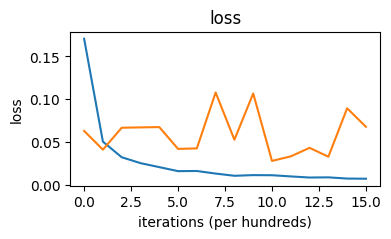

In [ ]:
# Initialize trackers
best_acc = 0
best_loss = 0.0
early_stop_cnt = 0
train_losses = []
val_losses = []
train_acc_record = []
val_acc_record = []
batch_loss = []
batch_val_loss = []

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)

# cross-entropy
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weigth_decay)

# ================================ #
# Haven't implememt early stop yet #
# ================================ #

for epoch in range(num_epochs):

        print(f"\n--> starting epoch {epoch + 1}")

        ### ==== Training ==== ###
        # set model to train mode
        model.train()

        # record information in training.
        train_loss = []
        train_accs = []


        for batch in tqdm(train_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch


            # Put images through the model
            outputs = model(imgs.to(device))
            # Calculate the cross-entropy loss.
            loss = criterion(outputs, labels.to(device))

            # Gradients stored in the parameters in the previous step should be cleared out first.
            optimizer.zero_grad()

            # Compute the gradients for parameters.
            loss.backward()

            # Clip the gradient norms for stable training.
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

            # Update the parameters with computed gradients.
            optimizer.step()

            # Compute the accuracy for current batch.
            acc = (outputs.argmax(dim=-1) == labels.to(device)).float().mean()
            ans = outputs.argmax(dim=-1)


            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc.item())

        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        # Print the information.
        train_losses.append(train_loss)
        train_acc_record.append(train_acc)
        print(f"[ Train ] | [{epoch + 1:04d}/{num_epochs:04d}] ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")


        ### ==== Validation ==== ###
        # model eval mode
        model.eval()

        # record information in validation.
        valid_loss = []
        valid_accs = []

        for batch in tqdm(valid_loader):

            imgs, labels = batch


            # torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                outputs = model(imgs.to(device))

            # compute loss
            loss = criterion(outputs, labels.to(device))

            # Compute the accuracy
            acc = (outputs.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record loss and accuracy.
            valid_loss.append(loss.item())
            valid_accs.append(acc.item())

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)


        # Print the information.
        val_losses.append(valid_loss)
        val_acc_record.append(valid_acc)
        print(f"[ Valid | [{epoch + 1:04d}/{num_epochs:04d}] ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


        # we can use txt to record training process
        """
        # update logs
        if valid_acc > best_acc:
            with open(f"./{_exp_name}_log.txt","a") as log:
                log.writelines(f"[ Valid | [{epoch + 1:04d}/{num_epochs:04d}] ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best\n")
        else:
            with open(f"./{_exp_name}_log.txt","a") as log:
                log.writelines(f"[ Valid | [{epoch + 1:04d}/{num_epochs:04d}] ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}\n")
        """
        # save models
        if valid_acc > best_acc:
            print(f"==== Best model found at epoch {epoch+1}, saving model ====")
            torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
            torch.save(model.state_dict(), f"/content/drive/MyDrive/{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
            best_acc = valid_acc
            best_loss = valid_loss
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        if early_stop_cnt >= early_stop_steps:
            # early stop
            print(f'early stop at epoch {epoch}')
            break

print(f'\n==> best acc: {best_acc: .4f} best loss : {best_loss: .4f}\n')
# plot the loss
plt.figure(figsize=(4, 2))
plt.plot(np.squeeze(train_losses), label = "train")
plt.plot(np.squeeze(val_losses), label = "val")
plt.ylabel('loss')
plt.xlabel('iterations (per hundreds)')
plt.title("loss")
plt.show()

### Make Predictions

  0%|          | 0/12 [00:00<?, ?it/s]

[ DATA DISTRIBUTION ] | [ FAKE ] : 5378 | [ REAL ] : 2550
One /content/drive/MyDrive/ sample /content/drive/MyDrive/source_faces/test/1_1_725_0400.jpg


  0%|          | 0/124 [00:00<?, ?it/s]

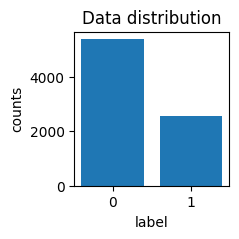

[ Test ] loss = 0.11180, acc = 0.97732


In [ ]:
test_set = FaceDataset(_dataset_dir, "test", tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

model_best = Classifier().to(device)

model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.eval()
prediction = []
test_loss = []
test_acc = []
with torch.no_grad():
    test_0 = 0
    test_1 = 0
    for data,labels in tqdm(test_loader):
        test_pred = model_best(data.to(device))
        acc = (test_pred.argmax(dim=-1) == labels.to(device)).float().mean()
        loss = criterion(test_pred, labels.to(device))

        test_loss.append(loss.item())
        test_acc.append(acc)

        test_0 += len(['_' for i in test_pred.argmax(dim=-1) if i == 0])
        test_1 += len(['_' for i in test_pred.argmax(dim=-1) if i == 1])
    plt.figure(figsize=(2, 2))
    plt.bar([0, 1], [test_0, test_1])
    plt.title('Data distribution')
    plt.xlabel('label')
    plt.ylabel('counts')
    plt.show()

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    final_loss = sum(test_loss) / len(test_loss)
    final_acc = sum(test_acc) / len(test_acc)

    # Print the information.
    print(f"[ Test ] loss = {final_loss:.5f}, acc = {final_acc:.5f}")